<a href="https://colab.research.google.com/github/AbhishekHosmani/Stance-Detection-NLP/blob/main/lstm_w2v_wiki.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Emotion Classification in texts using LSTM and Word2Vec

### Architecture: 
(X) Text -> Embedding (W2V pretrained on wikipedia articles) -> Deep Network (LSTM/GRU) -> Fully connected (Dense) -> Output Layer (Softmax) -> Emotion class (Y)

#### Embedding Layer
* Word Embedding is a representation of text where words that have the similar meaning have a similar representation. We will use 300 dimentional word vectors pre-trained on wikipedia articles. We can also train the w2v model with our data, however our dataset is quite small and trained word vectors might not be as good as using pretrained w2v.

#### Deep Network
* Deep network takes the sequence of embedding vectors as input and converts them to a compressed representation. The compressed representation effectively captures all the information in the sequence of words in the text. The deep network part is usually an RNN or some forms of it like LSTM/GRU. The dropout can be added to overcome the tendency to overfit, a very common problem with RNN based networks.

#### Fully Connected Layer
* The fully connected layer takes the deep representation from the RNN/LSTM/GRU and transforms it into the final output classes or class scores. This component is comprised of fully connected layers along with batch normalization and optionally dropout layers for regularization.

#### Output Layer
* Based on the problem at hand, this layer can have either Sigmoid for binary classification or Softmax for both binary and multi classification output.

## Workflow: 
1. Import Data
2. Prepare the input data
3. Import pre-trained W2V
4. Create Neural Network Pipeline
5. Train The Model
6. Evaluate results



👋  **Let's start** 

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:

%cd "/content/gdrive/MyDrive/NLP/Project/source"

/content/gdrive/MyDrive/NLP/Project/source


In [3]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

## 1. Import Data


In [4]:
import pandas as pd
import numpy as np

# text preprocessing
from nltk.tokenize import word_tokenize
import re

# plots and metrics
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

# preparing input to our model
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

# keras layers
from keras.models import Sequential
from keras.layers import Embedding, Bidirectional, LSTM, GRU, Dense

Defining vector space dimension and fixed input size

In [5]:
# Number of labels: joy, anger, fear, sadness, neutral
num_classes = 5

# Number of dimensions for word embedding
embed_num_dims = 300

# Max input length (max number of words) 
max_seq_len = 500

class_names = ['joy', 'fear', 'anger', 'sadness', 'neutral']

Importing our training and testing datasets

In [6]:
data_train = pd.read_csv('data/data_train.csv', encoding='utf-8')
data_test = pd.read_csv('data/data_test.csv', encoding='utf-8')

X_train = data_train.Text
X_test = data_test.Text

y_train = data_train.Emotion
y_test = data_test.Emotion

data = data_train.append(data_test, ignore_index=True)

In [17]:
print(data.Emotion.value_counts())
data.head(6)

joy        2326
sadness    2317
anger      2259
neutral    2254
fear       2171
Name: Emotion, dtype: int64


,Emotion,Text
0,neutral,There are tons of other paintings that I thin...
1,sadness,"Yet the dog had grown old and less capable , a..."
2,fear,When I get into the tube or the train without ...
3,fear,This last may be a source of considerable disq...
4,anger,She disliked the intimacy he showed towards so...
5,sadness,When my family heard that my Mother's cousin w...


## 2. Prepare input data
To input the data to our NN Model we'll need some preprocessing:
1. Tokenize our texts and count unique tokens
2. Padding: each input (sentence or text) has to be of the same lenght
3. Labels have to be converted to integeres and categorized

Basic preprocessing and tokenization using nltk to double check that sentences are properly split into words.
We could also add stopword removal but steps like stemming or lemmatization are not needed since we are using word2vec and words with the same stem can have a different meaning

In [18]:
def clean_text(data):
    
    # remove hashtags and @usernames
    data = re.sub(r"(#[\d\w\.]+)", '', data)
    data = re.sub(r"(@[\d\w\.]+)", '', data)
    
    # tekenization using nltk
    data = word_tokenize(data)
    
    return data

*Making things easier for keras tokenizer 🙃

In [20]:
import nltk
nltk.download('punkt')

texts = [' '.join(clean_text(text)) for text in data.Text]

texts_train = [' '.join(clean_text(text)) for text in X_train]
texts_test = [' '.join(clean_text(text)) for text in X_test]

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [21]:
print(texts_train[92])

a bit ? I 'm extremely annoyed that he did n't phone me when he promised me that he would ! He 's such a liar .


**Tokenization + fitting using keras**

In [22]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts)

sequence_train = tokenizer.texts_to_sequences(texts_train)
sequence_test = tokenizer.texts_to_sequences(texts_test)

index_of_words = tokenizer.word_index

# vacab size is number of unique words + reserved 0 index for padding
vocab_size = len(index_of_words) + 1

print('Number of unique words: {}'.format(len(index_of_words)))

Number of unique words: 12088


**Padding** -> each input has the same length

We defined maximun number of words for our texts and input size to our model has to be fixed - padding with zeros to keep the same input lenght (longest input in our dataset is ~250 words)

In [23]:
X_train_pad = pad_sequences(sequence_train, maxlen = max_seq_len )
X_test_pad = pad_sequences(sequence_test, maxlen = max_seq_len )

X_train_pad

array([[    0,     0,     0, ...,   119,    51,   345],
       [    0,     0,     0, ...,    37,   277,   154],
       [    0,     0,     0, ...,    16,     2,  1210],
       ...,
       [    0,     0,     0, ...,   876,     4,   909],
       [    0,     0,     0, ...,     1,     6,   117],
       [    0,     0,     0, ..., 10259,   173,    13]], dtype=int32)

**Categorize** labels: 

In [24]:
encoding = {
    'joy': 0,
    'fear': 1,
    'anger': 2,
    'sadness': 3,
    'neutral': 4
}

# Integer labels
y_train = [encoding[x] for x in data_train.Emotion]
y_test = [encoding[x] for x in data_test.Emotion]

In [25]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

y_train

array([[0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0.],
       ...,
       [0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.]], dtype=float32)

## 2. Import pretrained word vectors

* Importing pretrained word2vec from file and creating embedding matrix
* We will later map each word in our corpus to existing word vector

In [26]:
def create_embedding_matrix(filepath, word_index, embedding_dim):
    vocab_size = len(word_index) + 1  # Adding again 1 because of reserved 0 index
    embedding_matrix = np.zeros((vocab_size, embedding_dim))
    with open(filepath) as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word] 
                embedding_matrix[idx] = np.array(
                    vector, dtype=np.float32)[:embedding_dim]
    return embedding_matrix

You can download and import any pre-trained word embeddings. I will use 300 dimentional w2v pre-trained on wikipedia articles. Download fast text english vectors: https://fasttext.cc/docs/en/english-vectors.html

In [27]:
import urllib.request
import zipfile
import os

fname = 'embeddings/wiki-news-300d-1M.vec'

if not os.path.isfile(fname):
    print('Downloading word vectors...')
    urllib.request.urlretrieve('https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M.vec.zip',
                              'wiki-news-300d-1M.vec.zip')
    print('Unzipping...')
    with zipfile.ZipFile('wiki-news-300d-1M.vec.zip', 'r') as zip_ref:
        zip_ref.extractall('embeddings')
    print('done.')
    
    os.remove('wiki-news-300d-1M.vec.zip')

Unzipping...
done.


In [29]:
embedd_matrix = create_embedding_matrix(fname, index_of_words, embed_num_dims)
embedd_matrix.shape

(12089, 300)

Some of the words from our corpus were not included in the pre-trained word vectors. If we inspect those words we'll see that it's mostly spelling errors. It's also good to double check the noise in our data f.e different languages or tokenizer errors.

In [32]:
# Inspect unseen words
new_words = 0

for word in index_of_words:
    entry = embedd_matrix[index_of_words[word]]
    if all(v == 0 for v in entry):
        new_words = new_words + 1

print('Words found in wiki vocab: ' + str(len(index_of_words) - new_words))
print('New words found: ' + str(new_words))

Words found in wiki vocab: 11442
New words found: 646


## 3. Create LSTM Pipeline

### Embedding Layer

We will use pre-trained word vectors. We could also train our own embedding layer if we don't specify the pre-trained weights 

* **vocabulary size:** the maximum number of terms that are used to represent a text: e.g. if we set the size of the “vocabulary” to 1000 only the first thousand terms most frequent in the corpus will be considered (and the other terms will be ignored)
* **the maximum length:** of the texts (which must all be the same length)
* **size of embeddings:** basically, the more dimensions we have the more precise the semantics will be, but beyond a certain threshold we will lose the ability of the embedding to define a coherent and general enough semantic area
* **trainable:** True if you want to fine-tune them while training


In [33]:
# Embedding layer before the actaul BLSTM 
embedd_layer = Embedding(vocab_size,
                         embed_num_dims,
                         input_length = max_seq_len,
                         weights = [embedd_matrix],
                         trainable=False)

### Model Pipeline
- the input is the first N words of each text (with proper padding)
- the first level creates embedding of words, using vocabulary with a certain dimension, and a given size of embeddings
- LSTM/GRU layer which will receive word embeddings for each token in the tweet as inputs. The intuition is that its output tokens will store information not only of the initial token, but also any previous tokens; In other words, the LSTM layer is generating a new encoding for the original input.
- the output level has a number of neurons equal to the classes of the problem and a “softmax” activation function

You can change GRU to LSTM. The results will be very similar but LSTM might take longer to train.

In [34]:
# Parameters
gru_output_size = 128
bidirectional = True

# Embedding Layer, LSTM or biLSTM, Dense, softmax
model = Sequential()
model.add(embedd_layer)

if bidirectional:
    model.add(Bidirectional(GRU(units=gru_output_size,
                              dropout=0.2,
                              recurrent_dropout=0.2)))
else:
     model.add(GRU(units=gru_output_size,
                dropout=0.2, 
                recurrent_dropout=0.2))

model.add(Dense(num_classes, activation='softmax'))

In [35]:
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 500, 300)          3626700   
_________________________________________________________________
bidirectional (Bidirectional (None, 256)               330240    
_________________________________________________________________
dense (Dense)                (None, 5)                 1285      
Total params: 3,958,225
Trainable params: 331,525
Non-trainable params: 3,626,700
_________________________________________________________________


## 3. Train the Model

* **validation data**: use validation_split in order to estimate how well your model has been trained and adjust parameters or add dropout layers. After that we will train the model using the complete train set.
* **epochs**: 15 **batch_size**: 128 

In [36]:
batch_size = 128
epochs = 15

hist = model.fit(X_train_pad, y_train, 
                 batch_size=batch_size,
                 epochs=epochs,
                 validation_data=(X_test_pad,y_test))

Epoch 1/15
62/62 [==============================] - 342s 5s/step - loss: 1.5132 - accuracy: 0.3220 - val_loss: 1.2764 - val_accuracy: 0.4668
Epoch 2/15
62/62 [==============================] - 337s 5s/step - loss: 1.1769 - accuracy: 0.5209 - val_loss: 0.9691 - val_accuracy: 0.6472
Epoch 3/15
62/62 [==============================] - 344s 6s/step - loss: 0.8924 - accuracy: 0.6743 - val_loss: 0.8469 - val_accuracy: 0.6902
Epoch 4/15
62/62 [==============================] - 340s 5s/step - loss: 0.8107 - accuracy: 0.7074 - val_loss: 0.7944 - val_accuracy: 0.7126
Epoch 5/15
62/62 [==============================] - 338s 5s/step - loss: 0.7675 - accuracy: 0.7161 - val_loss: 0.7958 - val_accuracy: 0.7082
Epoch 6/15
62/62 [==============================] - 339s 5s/step - loss: 0.7267 - accuracy: 0.7417 - val_loss: 0.7658 - val_accuracy: 0.7218
Epoch 7/15
62/62 [==============================] - 340s 5s/step - loss: 0.6815 - accuracy: 0.7518 - val_loss: 0.7655 - val_accuracy: 0.7197
Epoch 8/15
62

In [1]:
#Accuracy
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# "Loss"
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

NameError: ignored

## 4. Evaluation

In [ ]:
predictions = model.predict(X_test_pad)
predictions = np.argmax(predictions, axis=1)
predictions = [class_names[pred] for pred in predictions]

In [ ]:
print("Accuracy: {:.2f}%".format(accuracy_score(data_test.Emotion, predictions) * 100))
print("\nF1 Score: {:.2f}".format(f1_score(data_test.Emotion, predictions, average='micro') * 100))

Accuracy: 73.56%

F1 Score: 73.56


#### Plotting confusion Matrix:

In [ ]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    '''
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    '''
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots()
    
    # Set size
    fig.set_size_inches(12.5, 7.5)
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.grid(False)
    
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


F1 Score: 73.56


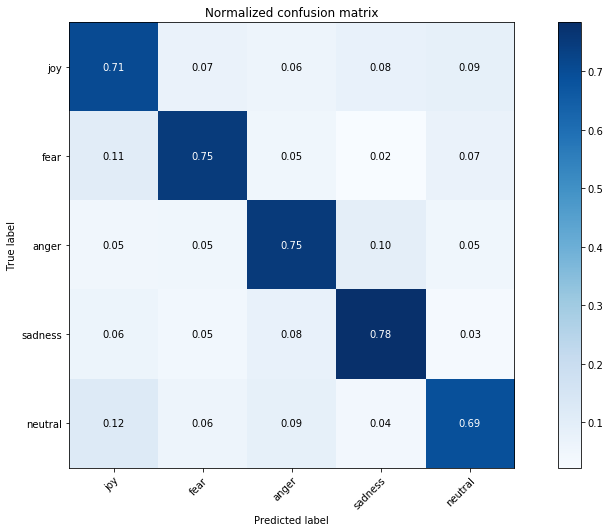

In [ ]:
print("\nF1 Score: {:.2f}".format(f1_score(data_test.Emotion, predictions, average='micro') * 100))

# Plot normalized confusion matrix
plot_confusion_matrix(data_test.Emotion, predictions, classes=class_names, normalize=True, title='Normalized confusion matrix')
plt.show()

#### Lets try other inputs:

In [ ]:
print('Message: {}\nPredicted: {}'.format(X_test[4], predictions[4]))

Message: My boyfriend didn't turn up after promising that he was coming.
Predicted: sadness


In [30]:
import time

message = ['delivery was hour late and my pizza was cold!']

seq = tokenizer.texts_to_sequences(message)
padded = pad_sequences(seq, maxlen=max_seq_len)

start_time = time.time()
pred = model.predict(padded)

print('Message: ' + str(message))
print('predicted: {} ({:.2f} seconds)'.format(class_names[np.argmax(pred)], (time.time() - start_time)))

NameError: ignored

# Done
Save the model for later use 🙃 

In [ ]:
# creates a HDF5 file 'my_model.h5'
model.save('models/biLSTM_w2v.h5')

In [27]:
import json
from keras.models import load_model
from keras.preprocessing.text import Tokenizer

model = load_model('models/biLSTM_w2v.h5')

def read_tweets_data(tweets_jsonl_file):
    tweets_data = []
    with open(tweets_jsonl_file, 'r') as f:
        json_list = list(f)
    for json_str in json_list:
        result = json.loads(json_str)
        tweets_data.append(result)
    return tweets_data


def get_emotion_of_tweet(model, tweet, max_seq_len=500):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(tweet)
    seq = tokenizer.texts_to_sequences(tweet)
    padded_tweet = pad_sequences(seq, maxlen=max_seq_len)
    pred = model.predict(padded_tweet)
    print('Tweet: ' + str(tweet))
    print('predicted: {}'.format(class_names[np.argmax(pred)]))  



tweets_path = "/content/gdrive/MyDrive/NLP/Project/tweets/train_tweets.jsonl"
test_data = read_tweets_data(tweets_path)
for sample in test_data:
  test_tweet = [sample['text']]
  get_emotion_of_tweet(model, test_tweet, 500)


Tweet: ['Human immune system has a higher success rate than the vaccine. URL QT: "Have you gotten the COVID vaccine"']
predicted: anger
Tweet: ['Covid Vaccine is the new version of populationg control to combat climate change.']
predicted: anger
Tweet: ['Do not take the COVID-19 vaccine. You will never be the same.']
predicted: joy
Tweet: ['@stealthbadger @oneconnelly1 Something in the "the microchip in the covid vaccine uses 5G" family of conspiracy theories.  Maybe it needs the 5G to track people, maybe needs the 5G to transmit the mind control signals, or to power the chip.  I have heard a few.']
predicted: sadness
Tweet: ['The Pope of Rome declares that "the use of the vaccine does not in any way imply that there is a moral endorsement of the use of aborted fetus cells."  Taking the vaccine does indeed support the use of aborted fetuses in covid 19 vaccine.']
predicted: sadness
Tweet: ['These people were probably naturally immune to it.  The vaccine destroyed their immune system an

source/  tweets/  X3_annotations_axr190014.jsonl
